# LightGBM Train

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/RecSys2024/
base_path = '/content/drive/MyDrive/RecSys2024/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Exp_Recsys2024_LGBM_train.ipynb  output				     Recsys2024_ensemble.ipynb
Exp_Recsys2024_preprocess.ipynb  preprocess2_embed_similarity.ipynb  Recsys2024_LGBM_test.ipynb
feature_output			 preprocess2.ipynb		     Recsys2024_LGBM_train.ipynb
input				 preprocess_article.ipynb	     Recsys2024_preprocess.ipynb
models				 preprocess_create_embed.ipynb
old_Recsys2024_LGBM_train.ipynb  Recsys2024_EDA.ipynb


In [2]:
import pandas as pd
import polars as pl
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
input_path = base_path + 'input'

In [5]:
data = pd.read_csv(input_path + '/recsys_metrics.csv')

Correlations with AUC:
MRR        0.987953
NDCG@5     0.993732
NDCG@10    0.992189
Name: AUC, dtype: float64


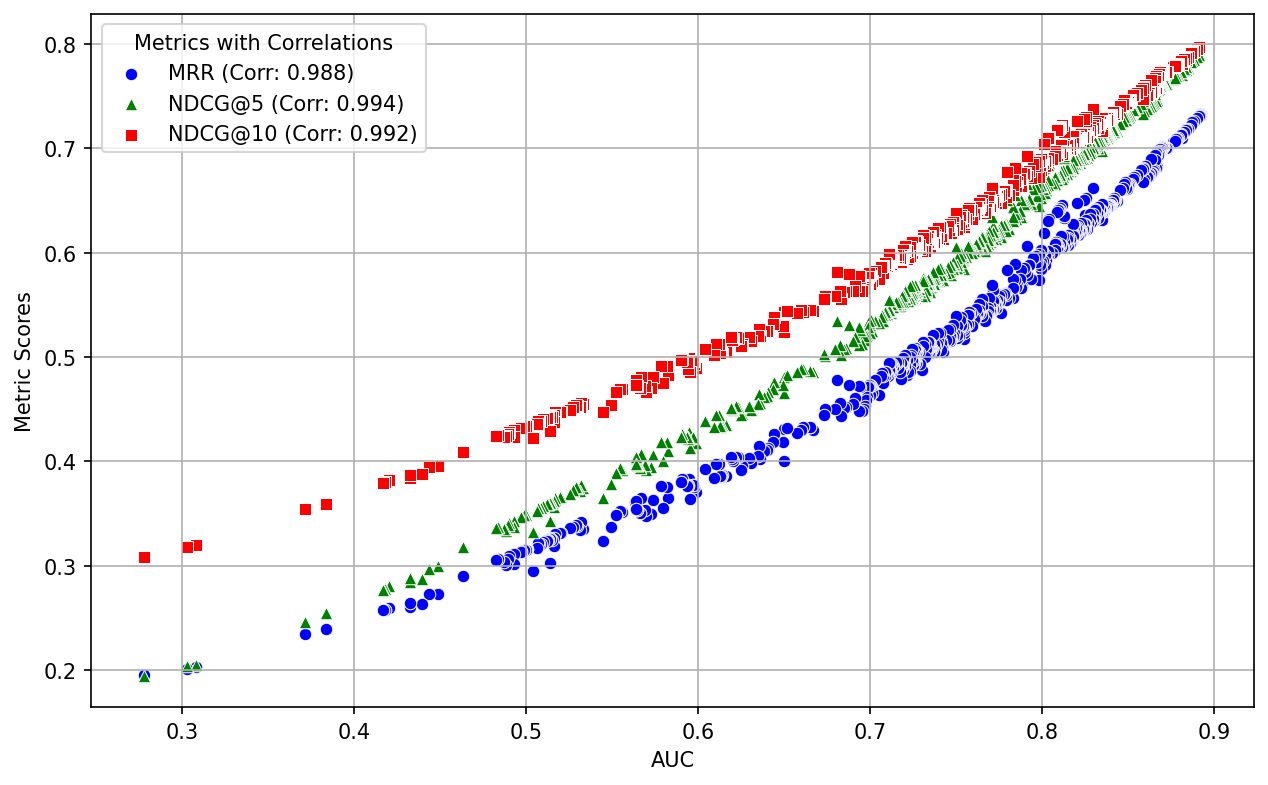

In [26]:
# 相関係数を表示するプロットの改善（さらに精密な表示）
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6), dpi=150)  # DPIを150に設定

# 相関係数の計算
correlations = data.corr()['AUC'][['MRR', 'NDCG@5', 'NDCG@10']]
print("Correlations with AUC:")
print(correlations)

#plt.figure(figsize=(10, 6))
sns.scatterplot(x='AUC', y='MRR', data=data, marker='o', color='blue', label=f'MRR (Corr: {correlations["MRR"]:.3f})')
sns.scatterplot(x='AUC', y='NDCG@5', data=data, marker='^', color='green', label=f'NDCG@5 (Corr: {correlations["NDCG@5"]:.3f})')
sns.scatterplot(x='AUC', y='NDCG@10', data=data, marker='s', color='red', label=f'NDCG@10 (Corr: {correlations["NDCG@10"]:.3f})')

#plt.title('Relationship between AUC and Ranking Metrics')
plt.xlabel('AUC')
plt.ylabel('Metric Scores')
plt.legend(title='Metrics with Correlations')
plt.grid(True)
plt.show()

In [4]:
data = pd.read_csv(input_path + '/recsys_local.csv')

In [5]:
data

,nDCG@10 (Local),nDCG@10 (LB),Description,type
0,0.596856,0.6013,NaN,train only
1,0.596856,0.6161,baseline features\n(nFeatures=42),train+valid
2,0.645803,0.6692,NaN,train only
3,0.645803,0.6713,add interactive features\n(nFeatures=119),train+valid
4,0.668764,0.6919,add_session_features\n(nFeatures=126),train+valid
5,0.672581,0.6996,add imp time and embedding features\n(nFeature...,train+valid


i= 0 row= nDCG@10 (Local)      0.596856
nDCG@10 (LB)           0.6013
Description               NaN
type               train only
Name: 0, dtype: object
i= 1 row= nDCG@10 (Local)                             0.596856
nDCG@10 (LB)                                  0.6161
Description        baseline features\n(nFeatures=42)
type                                     train+valid
Name: 1, dtype: object
i= 2 row= nDCG@10 (Local)      0.645803
nDCG@10 (LB)           0.6692
Description               NaN
type               train only
Name: 2, dtype: object
i= 3 row= nDCG@10 (Local)                                     0.645803
nDCG@10 (LB)                                          0.6713
Description        add interactive features\n(nFeatures=119)
type                                             train+valid
Name: 3, dtype: object
i= 4 row= nDCG@10 (Local)                                 0.668764
nDCG@10 (LB)                                      0.6919
Description        add_session_features\n(nFeatu

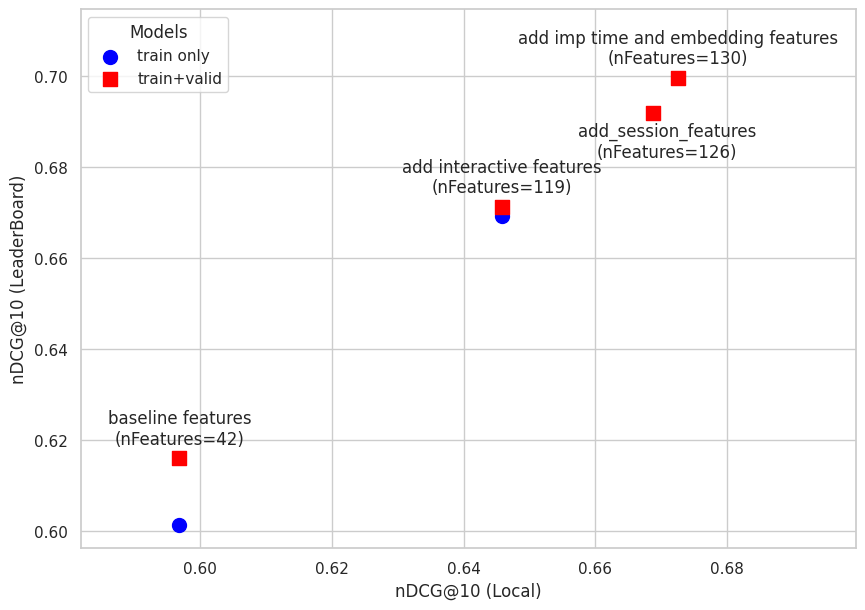

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
sns.set(style="whitegrid")

# Define markers for each unique type
markers = ['o', 's', 'D', '^', '*']  # Different shapes for markers
unique_types = data['type'].unique()
marker_dict = dict(zip(unique_types, markers))

# Define colors for each unique type
#colors = sns.color_palette("hsv", len(unique_types))
colors = ['blue', 'red']
color_dict = dict(zip(unique_types, colors))

# Plotting
plt.figure(figsize=(10, 7))
for typ in unique_types:
    subset = data[data['type'] == typ]
    plt.scatter(subset['nDCG@10 (Local)'], subset['nDCG@10 (LB)'],
                s=100, label=f'{typ}', marker=marker_dict[typ],
                color=color_dict[typ])
# Adjusting x-axis and y-axis limits
xmax = data['nDCG@10 (Local)'].max() + 0.027  # Adding a buffer for visibility
ymax = data['nDCG@10 (LB)'].max() + 0.015
xmin = data['nDCG@10 (Local)'].min() - 0.015
ymin = data['nDCG@10 (LB)'].min() - 0.005
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# Add annotations for descriptions
for i, row in data.iterrows():
    xoff = 0
    yoff = 10
    if i == 4:
        xoff = 10
        yoff = -32
    print('i=',i,'row=', row)
    if pd.notna(row['Description']):
        plt.annotate(row['Description'],
                     (row['nDCG@10 (Local)'], row['nDCG@10 (LB)']),
                     textcoords="offset points", # using offset
                     xytext=(xoff,yoff), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right
        #plt.text(row['nDCG@10 (Local)'], row['nDCG@10 (LB)'],
        #         '  ' + str(row['Description']), verticalalignment='bottom')

# Add legend, labels, and title
plt.legend(title="Models", loc='upper left')
plt.xlabel("nDCG@10 (Local)")
plt.ylabel("nDCG@10 (LeaderBoard)")
#plt.title("Comparison of nDCG@10 Scores")
plt.show()